Bibliotecas

In [3]:
import warnings
import random
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns # pip install seaborn
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler # pip install imbalanced-learn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Lectura del conjunto de datos

In [4]:
# Asegurar reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

df = pd.read_csv("mort_hospital.csv")

**Problema**: Alto número de columnas con datos no informados

In [5]:
df.isnull().any().sum()

175

**Problema**: Presencia de variables no numéricas

In [8]:
object_columns = df.select_dtypes(include=['object']).columns
cols = df.select_dtypes([np.number]).columns
print("Columnas con datos categóricos:", len(object_columns))
print("Columnas con datos numéricos:", len(cols))

Columnas con datos categóricos: 8
Columnas con datos numéricos: 178


**Problema**: Las clases de la variable de interés están muy desequilibradas

<Axes: xlabel='hospital_death', ylabel='count'>

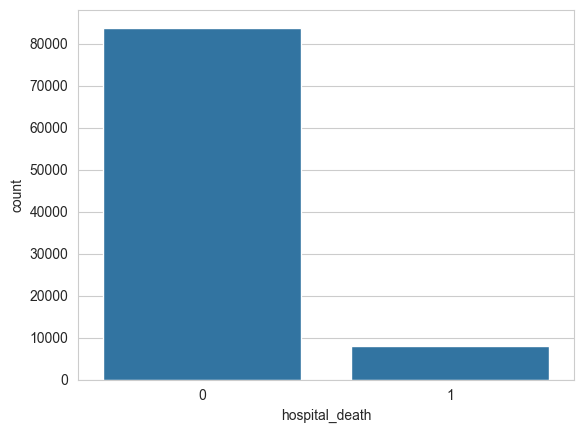

In [7]:
sns.set_style('whitegrid')
sns.countplot(x='hospital_death',data=df)

Solución al problema de los datos no informados:
- Variables categóricas: rellenar con la moda
- Variables numéricas: rellenar con el promedio

In [9]:
for i in object_columns:
    df[i].fillna(df[i].mode()[0], inplace=True)

df[cols] = df[cols].fillna(df[cols].mean())

Solución al problema de las variables no numéricas:
- Codificación de variables categóricas

In [10]:
print("Valores de la variable 'etnicity' antes de la codificación:", df['ethnicity'].unique())
le = LabelEncoder()
df[object_columns] = df[object_columns].apply(le.fit_transform)
print("Valores de la variable 'etnicity' después de la codificación:", df['ethnicity'].unique())

Valores de la variable 'etnicity' antes de la codificación: ['Caucasian' 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown']
Valores de la variable 'etnicity' después de la codificación: [2 3 0 1 4 5]


Solución al problema del desequilibrio de la variable de interés:
- Muestreo de la clase más numerosa

In [11]:
X = df.drop(columns='hospital_death', axis=1)
y = df['hospital_death']

undersample = RandomUnderSampler(sampling_strategy='majority', random_state=SEED)
X, y = undersample.fit_resample(X, y)

print("Recuento de categorías de salida:", Counter(y))

Recuento de categorías de salida: Counter({0: 7915, 1: 7915})


Selección de características

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

num_k = 50
# El parámetro k determina cuántas características se seleccionan
# El parámetro input_dim de la primera capa de la red deberá ser num_k
kmejores = SelectKBest(mutual_info_classif, k=num_k)
kmejores.fit(X_train, y_train)
X_train.columns[kmejores.get_support()]
X_train_new = kmejores.transform(X_train)
X_test_new =  kmejores.transform(X_test)

Normalización de datos

In [13]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_new)
X_test_std = scaler.transform(X_test_new)

### Solución de la tarea 2
**Objetivos**
- Entender el código proporcionado: tratamiento de datos no informados, codificación de variables categóricas, equilibrado de categorías de la variable de interés, selección de características y normalización.
- Diseñar y entrenar una red neuronal para predecir la variable 'hospital_death':
    - Probar con distintos valores de 'num_k' para cambiar el número de características seleccionadas.
    - Diseñar un modelo secuencial ('Sequential()'), cuya primera capa debe especificar como 'input_dim' el valor 'num_k', probando distintos números de capas, funciones de activación (RELU y variantes para las capas ocultas, sigmoide para la capa final), número de neuronas en cada capa, capas 'Dropout', etc.
    - Compilar el modelo estableciendo una función de error ('loss'), el optimizador (puedes cambiar el parámetro 'learning_rate') y las métricas de rendimiento que se calcularán.
    - Ajustar el modelo con los datos de entrenamiento estableciendo para la función 'fit' el número de iteraciones ('epochs'), el porcentaje de datos de validación ('validation_split') y el tamaño de lote para la retropropagación ('batch_size').
- **OPCIONAL**: En lugar de cablear en el código los parámetros anteriores y modificarlos a mano, se valorará muy positivamente la escritura de un programa que genere dinámicamente diferentes arquitecturas probando distintos valores para todos o algunos de los parámetros del punto anterior.

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import numpy as np
import random
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Función para generar valores aleatorios en los rangos
def sample_from_range(param):
    if param["type"] == "continuous":
        return round(random.uniform(param["min"], param["max"]) // param["step"] * param["step"], 5)
    elif param["type"] == "discrete":
        return random.randrange(param["min"], param["max"] + 1, param.get("step", 1))

# Parametros de búsqueda
param_space = {
    "dropout_rate": {"min": 0.2, "max": 0.5, "step": 0.05, "type": "continuous"},
    "learning_rate": {"min": 0.0001, "max": 0.01, "step": 0.0005, "type": "continuous"},
    "num_hidden_layers": {"min": 2, "max": 3, "type": "discrete"},
    "batch_size": {"min": 16, "max": 64, "step": 16, "type": "discrete"}
}

# Generar 30 configuraciones aleatorias
n_trials = 30
random_combinations = [
    {key: sample_from_range(param_space[key]) for key in param_space}
    for _ in range(n_trials)
]

# Función para construir y evaluar un modelo
def build_and_evaluate_model(X_train, y_train, params):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(params["dropout_rate"]))

    for _ in range(int(params["num_hidden_layers"]) - 1):
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(params["dropout_rate"]))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=params["learning_rate"]),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Función para realizar k-fold cross-validation
def cross_validate_model(X, y, params, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=SEED)
    auc_train_scores = []
    auc_test_scores = []

    X = np.array(X)
    y = np.array(y)
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Construir y entrenar el modelo
        model = build_and_evaluate_model(X_train, y_train, params)
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=50, batch_size=int(params["batch_size"]),
                  callbacks=[early_stopping], verbose=0)
        
        y_train_pred = model.predict(X_train, verbose=0)
        y_val_pred = model.predict(X_val, verbose=0)

        auc_train = roc_auc_score(y_train, y_train_pred)
        auc_test = roc_auc_score(y_val, y_val_pred)
        
        auc_train_scores.append(auc_train)
        auc_test_scores.append(auc_test)

    # Promediar los resultados
    mean_auc_train = np.mean(auc_train_scores)
    mean_auc_test = np.mean(auc_test_scores)
    
    return mean_auc_train, mean_auc_test

# Entrenar y evaluar combinaciones con k-fold cross-validation
results = []

for params in random_combinations:
    print(f"Probando combinación: {params}")

    auc_train, auc_test = cross_validate_model(X_train_std, y_train, params)
    params["auc_train"] = auc_train
    params["auc_test"] = auc_test
    results.append(params)
    print(f"AUC-ROC (Train): {auc_train:.4f}, AUC-ROC (Test): {auc_test:.4f}")

# Seleccionar la mejor combinación basada en el AUC de Test
best_params = max(results, key=lambda x: x["auc_test"])
print("\nMejor combinación:")
print(best_params)

# Entrenar el modelo final con la mejor combinación
final_auc_train, final_auc_test = cross_validate_model(X_train_std, y_train, best_params)
print(f"AUC-ROC del modelo final (Train): {final_auc_train:.4f}, AUC-ROC del modelo final (Test): {final_auc_test:.4f}")

# Guardar el mejor modelo y parámetros
with open("best_model_params.json", "w") as f:
    json.dump(best_params, f)





Probando combinación: {'dropout_rate': 0.2, 'learning_rate': 0.0085, 'num_hidden_layers': 2, 'batch_size': 64}
AUC-ROC (Train): 0.8931, AUC-ROC (Test): 0.8763
Probando combinación: {'dropout_rate': 0.4, 'learning_rate': 0.009, 'num_hidden_layers': 2, 'batch_size': 48}
AUC-ROC (Train): 0.8882, AUC-ROC (Test): 0.8744
Probando combinación: {'dropout_rate': 0.25, 'learning_rate': 0.0015, 'num_hidden_layers': 3, 'batch_size': 32}
AUC-ROC (Train): 0.8956, AUC-ROC (Test): 0.8771
Probando combinación: {'dropout_rate': 0.35, 'learning_rate': 0.009, 'num_hidden_layers': 2, 'batch_size': 48}
AUC-ROC (Train): 0.8883, AUC-ROC (Test): 0.8757
Probando combinación: {'dropout_rate': 0.4, 'learning_rate': 0.0, 'num_hidden_layers': 3, 'batch_size': 32}
AUC-ROC (Train): 0.5655, AUC-ROC (Test): 0.5722
Probando combinación: {'dropout_rate': 0.2, 'learning_rate': 0.003, 'num_hidden_layers': 3, 'batch_size': 32}
AUC-ROC (Train): 0.8942, AUC-ROC (Test): 0.8763
Probando combinación: {'dropout_rate': 0.25, 'lear

Mi solución implementa un proceso para la optimización de hiperparámetros de un modelo de red neuronal utilizando una búsqueda aleatoria de configuraciones y validación cruzada k-fold.

### Resumen del flujo:

1. **Generación de configuraciones aleatorias**: 
   Definimos un espacio de hiperparámetros para la red neuronal, que incluye el `dropout_rate`, `learning_rate`, el número de `num_hidden_layers`, y el `batch_size`. Estos parámetros se muestrean aleatoriamente dentro de los rangos especificados para generar diferentes combinaciones que se prueban durante el proceso de entrenamiento.

2. **Construcción del modelo**: 
   Se construye una red neuronal de tipo secuencial con una capa densa inicial y capas adicionales de acuerdo con el número de capas ocultas especificado en cada configuración. La red usa la función de activación ReLU, con un `dropout_rate` para regularización y un optimizador Adam con una tasa de aprendizaje ajustada.

3. **Evaluación con validación cruzada**:
   Para cada combinación de hiperparámetros generada, se realiza una validación cruzada k-fold (por defecto k=5). En cada división del conjunto de datos, se entrena el modelo y se evalúa su rendimiento en términos de la métrica AUC-ROC tanto en los datos de entrenamiento como en los de validación.

4. **Selección de la mejor configuración**:
   Se calcula el promedio del AUC-ROC a través de todas las divisiones k-fold y se selecciona la combinación de hiperparámetros que logre el mejor rendimiento en el conjunto de validación.

5. **Entrenamiento final**:
   Con la mejor combinación de hiperparámetros, se entrena el modelo final y se guarda tanto el modelo como los parámetros en archivos JSON para su posterior uso o análisis.


